# Feature Extraction using CNN

Here we are attempting to train a small Convolution Neural Network to see if the neural network can extract features that can help us improve our classical algorithms.

One thing we are concerned about is the fact that classical algorithms cannot perform better tha CNNs. However, we aim to improve classical algorithms because they can run at a much faster speed. So if our CNN feature extractor paired with classical algorithms can perform just as well as original CNNs, it is promising that we can apply this to large datasets that CNN will take too long to run. One other thing is we can run classical algorithms in real time, meaning we can classify music much faster in real time than passing it through a CNN

This file will contain all code to extract features.

In [1]:
import os
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import librosa
import librosa.display as display

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

## Data loading

First we will load out date into the notebook so we can process them easily

In [3]:
X = np.load('data_mat/X2.npy')
Y = np.load('data_mat/Y2.npy')

In [4]:
print("training X shape is {0}".format(X.shape))
print("training Y shape is {0}".format(Y.shape))

training X shape is (500, 20, 1290)
training Y shape is (500, 5)


To apply the training set to the model easier, we will transform our data and split them so they can be fed into the models.

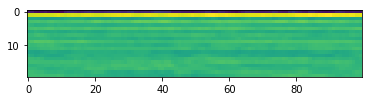

In [5]:
plt.imshow(X[0][:, :100])

training X shape is (500, 1290, 20)


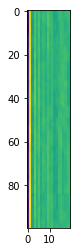

In [6]:
X2 = np.transpose(X, (0, 2, 1))
print("training X shape is {0}".format(X2.shape))
plt.imshow(X2[0][:100, :])

In [7]:
inds = np.arange(X2.shape[0])
np.random.shuffle(inds)
X_train, X_test, Y_train, Y_test = ms.train_test_split(X2[inds], Y[inds], test_size=0.2, random_state=123)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(400, 1290, 20) (100, 1290, 20) (400, 5) (100, 5)


## CNN modeling

Here we will use a 1D convolution layer, followed by standard pool, relu layers, followed by dense layers and then a softmax unit for output prediction.

In [8]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    print(X.shape)
    X = keras.layers.Conv1D(filters=4, kernel_size=32, dilation_rate=8,
                            padding='same', data_format="channels_last")(X)
    print(X.shape)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=32)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
#     X = keras.layers.Dropout(0.7)(X)    
    X = keras.layers.Conv1D(filters=20, kernel_size=16, dilation_rate=2, padding='valid', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=4)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
#     X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.Conv1D(filters=30, kernel_size=4, dilation_rate=1, padding='valid', data_format="channels_last")(X)
#     X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.AveragePooling1D(pool_size=4)(X)
#     X = keras.layers.BatchNormalization(axis = 2)(X)
#     X = keras.layers.Activation('relu')(X)
# #     X = keras.layers.Dropout(0.5)(X)    
#     print(X.shape)
#     X = keras.layers.Conv1D(filters=8, kernel_size=2, dilation_rate=2, padding='valid', data_format="channels_last")(X)
#     X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.MaxPooling1D(pool_size=2)(X)
#     X = keras.layers.BatchNormalization(axis = 2)(X)
#     X = keras.layers.Activation('relu')(X)
# #     X = keras.layers.Dropout(0.5)(X)    
#     print(X.shape)
    
    X = keras.layers.Flatten()(X)
#     X = keras.layers.Dense(20, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
# #     X = keras.layers.Dense(35, activation='sigmoid')(X)
#     X = keras.layers.Dense(10, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.Dense(30, activation='sigmoid')(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(5, activation='softmax')(X)
    print(X.shape)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [9]:
m = model(X2.shape[1:])
# optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

(?, 1290, 20)
(?, 1290, 4)
(?, 40, 4)
(?, 2, 20)
(?, 5)


In [10]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1290, 20)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1290, 4)           2564      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1290, 4)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 40, 4)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 4)             16        
_________________________________________________________________
activation_1 (Activation)    (None, 40, 4)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 20)            1300      
__________

In [ ]:
m.fit(X_train, Y_train, epochs=10, batch_size=64)

In [20]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

100/100 [==============================] - 0s 831us/step
Loss = 0.8870184230804443
Test Accuracy = 0.75


In [21]:
m.save('m1.h5')

### Feature extraction

Here we want to use the neural network that we trained to extract features

In [41]:
model = m
model.layers

In [42]:
print(model.layers[5], model.layers[11])


<keras.layers.core.Activation object at 0x00000208A8C64908> <keras.layers.core.Flatten object at 0x00000208A9EB7DD8>


In [43]:
def extract_all_features(X, model, layer_nums, batch_num):
    """Extract all the features by taking out the activation output of the layers specified in layer_nums
    
        X : the data that we are trying to extract features from
        model: the model that we are using to extract the features
        layer_nums: the layer number that we want to use as feature extractors
    """
    outputs = [model.layers[layer].output for layer in layer_nums]
    f = keras.backend.function([model.input, keras.backend.learning_phase()], outputs)
    ## split up into smaller chunks
    layer_outs = []
    m = X.shape[0]
    for i in range(batch_num):
        layer_outs += [f([X[(m // batch_num * i):(m // batch_num * (i+1)), :, :], 0.])]
    result = []
    for i in range(len(layer_nums)):
        layer_outs2 = []
        for batch in range(batch_num):
            activations = layer_outs[batch][i]
            activations = activations.reshape(activations.shape[0], -1)
            layer_outs2 += [activations]
        result += [np.vstack(np.array(layer_outs2))]
    return result

In [47]:
layer_outs_train = extract_all_features(X_train, model, [5, 11], 10)

In [48]:
layer_outs_test = extract_all_features(X_test, model, [5, 11], 1)

In [46]:
conv_3_train, conv_2_train, conv_1_train = layer_outs_train
conv_3_test, conv_2_test, conv_1_test = layer_outs_test
np.savetxt('conv_3_train.txt', conv_3_train)
np.savetxt('conv_2_train.txt', conv_2_train)
np.savetxt('conv_1_train.txt', conv_1_train)
np.savetxt('conv_3_test.txt', conv_3_test)
np.savetxt('conv_2_test.txt', conv_2_test)
np.savetxt('conv_1_test.txt', conv_1_test)
np.savetxt('Y_train.txt', Y_train)
np.savetxt('Y_test.txt', Y_test)

NameError: name 'layer_outs_train' is not defined

In [49]:
conv_2_train, conv_1_train = layer_outs_train
conv_2_test, conv_1_test = layer_outs_test
np.savetxt('conv_2_train.txt', conv_2_train)
np.savetxt('conv_1_train.txt', conv_1_train)
np.savetxt('conv_2_test.txt', conv_2_test)
np.savetxt('conv_1_test.txt', conv_1_test)
np.savetxt('Y_train.txt', Y_train)
np.savetxt('Y_test.txt', Y_test)

In [50]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)

## PCA

Here we will run PCA to visualize the 2 features we have extracted.